In [1]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import statistics
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import gensim
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases
from nltk import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim.downloader as api
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from preprocessing import *

In [2]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(inplace = True)
print(dataset.shape)

(3150, 5)
(3150, 5)
(2998, 5)
(2322, 5)


In [3]:
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 442, 0: 221})


In [5]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [7]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, True, 2)

total number of types extracted is: 2728


In [ ]:
# negative_reviews = list(dataset[dataset["feedback"] == 0]["verified_reviews"].values)
# print(len(negative_reviews))
# negative_text, negative_tok = tokenize_list_of_text(negative_reviews, custom_stopwords, False, pos_list)

In [ ]:
# print("loading pre trained embeddings, this can take some minutes...")
# glove_twitter_25 = KeyedVectors.load_word2vec_format('glove-twitter-25.txt', binary=False)
# print("loading complete.")

In [ ]:
# negative_artifical = generate_samples(negative_tok, 200, pre_trained_model = glove_twitter_25)
# new_sent_tok.extend(negative_artifical)
# len(negative_artifical)

In [8]:
# Elimino token con freq minore di 5
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)
# negative_artificial_cleaned = cleaned_reviews[-len(negative_artifical):] # estraggo le recensioni artificiali per poi aggiungerle esclusivamente al train
# del cleaned_reviews[-len(negative_artifical):] # le elimino dalle recensioni pulite

In [9]:
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI
bigrams[cleaned_reviews][2]

['little_JJ', 'feature_NNS']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)
# X_train.extend(negative_artificial_cleaned)
# Y_train.extend([0 for x in range(len(negative_artificial_cleaned))])

In [11]:
# Questa parte estrare le parole più rilevanti per ogni categoria, ma non la uso alla fine.
# Lo riprenderò più avanti
# FARE IL K-SQUARED

neg_tokenized = [rev for rev, feedback in zip(X_train, Y_train) if feedback == 0]
pos_tokenized = [rev for rev, feedback in zip(X_train, Y_train) if feedback == 1]
neg_tokenized = [w for rev in neg_tokenized for w in rev]
pos_tokenized = [w for rev in pos_tokenized for w in rev]

import math 

def get_pos_neg_score(pos, neg):

    # MI(word, category) = log2(p(word, category) / (p(word) * p(category)))


    total_tokens = pos + neg
    total_tokens_freq = nltk.FreqDist(total_tokens)
    pos_freq = nltk.FreqDist(pos)
    neg_freq = nltk.FreqDist(neg)
    data_dict = {"pos": {}, "neg": {}}

    for w in pos:
        p_category = pos_freq[w] / total_tokens_freq[w]
        p = pos_freq[w] / len(pos)
        data_dict["pos"][w] = -math.log2(p_category / (p))
    
    for w in neg:
        p_category = neg_freq[w] / total_tokens_freq[w]
        p = neg_freq[w] / len(neg)
        h = -math.log2(p)
        data_dict["neg"][w] = -math.log2(p_category / (p))

    pos_list = list(data_dict["pos"].values())
    neg_list = list(data_dict["neg"].values())
    scaled_pos = [(float(i)-min(pos_list))/(max(pos_list)-min(pos_list)) for i in pos_list]
    scaled_neg = [((float(i)-min(neg_list))/(max(neg_list)-min(neg_list))) - 1 for i in neg_list]

    data_dict["pos"] = {k: v for k, v in zip(data_dict["pos"], scaled_pos)}
    data_dict["neg"] = {k: v for k, v in zip(data_dict["neg"], scaled_neg)}
    
    pos_sorted = {k: v for k, v in sorted(data_dict["pos"].items(), key = lambda item: item[1], reverse=True)}
    neg_sorted = {k: v for k, v in sorted(data_dict["neg"].items(), key = lambda item: item[1], reverse=True)}
    data_dict["pos"] = pos_sorted
    data_dict["neg"] = neg_sorted

    risultato = {}

    for w in total_tokens:
        media = statistics.mean([data_dict["pos"].get(w, 0), data_dict["neg"].get(w, 0)])
        risultato[w] = media

    return {k: v for k, v in sorted(risultato.items(), key = lambda item: item[1], reverse=True)}

data_dict = get_pos_neg_score(pos_tokenized, neg_tokenized)

In [12]:
data_dict

{'great_JJ': 0.5,
 'like_IN': 0.42332153887303536,
 'one_CD': 0.39908986555476916,
 'love_VB': 0.39539913813361716,
 'device_NN': 0.37998276646956586,
 'product_NN': 0.3676659059161989,
 'love_VBP': 0.3676659059161989,
 'music_NN': 0.3634018280064694,
 'would_MD': 0.35008907861522987,
 'work_VBZ': 0.335916863890539,
 'time_NN': 0.335916863890539,
 'use_VB': 0.3309819795300265,
 'home_NN': 0.3044929042519686,
 'device_NNS': 0.3044929042519686,
 'get_VB': 0.29293270296885504,
 'sound_NN': 0.29293270296885504,
 'good_JJ': 0.2807299463995443,
 'buy_VBD': 0.2807299463995443,
 'thing_NN': 0.2807299463995443,
 'day_NN': 0.27436448295745636,
 'fun_NN': 0.2728341925943716,
 'easy_JJ_set_VB': 0.2728341925943716,
 'also_RB': 0.2610517335662168,
 'could_MD': 0.2610517335662168,
 'really_RB': 0.2540799380894573,
 'screen_NN': 0.24687951884152592,
 'still_RB': 0.231729159460005,
 'best_JJS': 0.22831552006986505,
 'still_RB_learn_VBG': 0.22831552006986505,
 'show_NN': 0.2237430752867693,
 'speaker_NN

In [13]:
# tfidf weighting sui token, per ora senza pos. Mi sono reso conto che la pos per averla più accurata la devo fare prima del pre processing.

tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 0)
tfidf_model = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)
review = 12
for score, feature in zip(tfidf_model.toarray()[review], tfidf.get_feature_names_out()):
    if score > 0.0:
        print(feature, score)

far_RB 0.392154188837494
full_JJ 0.4909352682003529
like_VBG 0.569342221883731
probably_RB 0.5301387450420418


In [14]:
tfidf.inverse_transform(tfidf_model)[0]

array(['thank_NN', 'excitement_NN', 'install_VB', 'product_NN',
       'wrong_JJ', 'receive_VBD'], dtype='<U23')

In [15]:
print(tfidf_model[0,:].data)
tfidf.inverse_transform(tfidf_model)[0]

[0.42785357 0.4447057  0.42785357 0.25863189 0.41408438 0.4447057 ]


array(['thank_NN', 'excitement_NN', 'install_VB', 'product_NN',
       'wrong_JJ', 'receive_VBD'], dtype='<U23')

In [16]:
w2v_model = Word2Vec(X_train, vector_size=100, window = 10, min_count = 0, sg=1, hs = 1, epochs= 100, seed = 5)

In [17]:
w2v_model.wv.most_similar("love_VB", topn = 10)

[('kitchen_NN', 0.3742702603340149),
 ('play_VB_music_NN', 0.356700599193573),
 ('convenient_JJ', 0.3494569659233093),
 ('love_VBP', 0.34535863995552063),
 ('assistant_NN', 0.3425735831260681),
 ('great_JJ', 0.3376261591911316),
 ('lyric_NNS', 0.33055680990219116),
 ('refurbish_VBN', 0.3303702473640442),
 ('wish_VB', 0.32613977789878845),
 ('absolutely_RB', 0.32443907856941223)]

In [18]:
w2v_model.wv.most_similar("love_VB", topn = 2000)[-10:]

[('actually_RB', -0.08428893238306046),
 ('plug_VBN', -0.08690248429775238),
 ('unmake_VB', -0.09089212119579315),
 ('issue_NN', -0.0945490226149559),
 ('reason_NN', -0.10560149699449539),
 ('useless_JJ', -0.11119332164525986),
 ('make_VBN', -0.11989811807870865),
 ('hue_NN', -0.127350851893425),
 ('know_VB', -0.12813396751880646),
 ('next_JJ', -0.17875605821609497)]

In [19]:
df = pd.DataFrame(tfidf_model.toarray(), columns = tfidf.get_feature_names_out())
df

,'ll_MD,'re_VBP,'ve_VBP,ability_NN,able_JJ,absolutely_RB,access_NN,account_NN,account_NNS,across_IN,...,work_VBN,work_VBP,work_VBZ,worth_IN,worth_JJ,would_MD,wrong_JJ,year_NN,yet_RB,zigbee_NN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.414084,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.223634,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188832,0.0,...,0.0,0.0,0.106035,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [20]:
g_model = []
# google_model = api.load('word2vec-google-news-300', True)
# g_model = KeyedVectors.load_word2vec_format(google_model, binary=True)

In [21]:
def review_vectors(tokens, size = 300, weights = [], pretrained = False):

    """Genera un vettore per ogni recensione: questo vettore
    è calcolato come la media ponderata (t * w: token vettore * peso tfidf) dei vettori dei token nella recensione.
    Il vettore risultante è normalizzato alla fine."""

    vec = np.zeros(size).reshape((1, size))
    count = 0

    import statistics

    # if len(tokens) != len(weights):
    #     print("nope")

    for word, weight in zip(tokens, weights):
        try:
            if pretrained:
                vec += g_model[word]
            else:
                vec += w2v_model.wv[word] * weight
            count +=1
        except KeyError:
            print("non trovo", word)
            continue

    if count!= 0:
        vec = vec / norm(vec)
        
    return vec

In [22]:
# qui viene creato per ogni recensione il vettore

w2v_X_train = np.zeros((len(X_train), w2v_model.vector_size))
for i in range(len(X_train)):
    w2v_X_train[i,:] = review_vectors(tfidf.inverse_transform(tfidf_model[i, :])[0], w2v_model.vector_size, tfidf_model[i,:].data, False)
w2v_df = pd.DataFrame(w2v_X_train)
w2v_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.027458,0.037735,-0.025692,-0.103405,0.256410,0.035165,-0.040675,-0.150663,0.178156,-0.091442,...,0.101562,-0.007172,0.027583,-0.054902,-0.025807,-0.014004,-0.021008,-0.043306,0.022475,-0.109678
1,0.014528,0.097922,0.019648,-0.117968,0.034791,0.087639,0.061084,-0.015135,0.138126,-0.042592,...,0.026739,0.023057,-0.078565,-0.061433,-0.069985,-0.076737,0.001125,0.039902,0.198252,0.017651
2,0.002055,-0.012593,-0.074919,-0.099591,0.268351,0.096752,-0.052650,0.024202,0.324977,-0.147755,...,0.113288,-0.027419,-0.089515,0.072074,-0.041764,0.151631,-0.134596,0.079685,0.178806,0.041552
3,0.005694,-0.117100,-0.066076,0.029199,0.124403,0.068955,-0.119594,-0.105762,0.007719,-0.188234,...,-0.051537,-0.086528,0.016678,-0.051273,0.075926,-0.011357,0.206026,0.103877,-0.194612,-0.009486
4,-0.110924,-0.073781,0.069521,0.017964,-0.012490,0.029771,0.007456,-0.248179,0.115102,-0.019262,...,0.027003,-0.015419,-0.287643,-0.020122,-0.001531,-0.017724,0.137040,0.063107,0.101166,0.278410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,-0.133356,0.051947,-0.116008,-0.095868,0.060887,0.008756,-0.200599,-0.094250,0.186471,-0.041901,...,0.046640,0.029370,-0.194588,0.018915,-0.007901,-0.044015,-0.052794,0.038343,0.056731,-0.017883
526,0.081215,-0.031144,0.006873,0.072927,0.109472,0.034658,0.039677,-0.131967,0.102453,-0.094051,...,-0.267670,-0.172193,0.011698,0.036667,-0.010118,-0.038407,-0.072803,0.034217,-0.038569,-0.001507
527,0.063204,0.037988,-0.126619,0.085372,0.156901,0.111157,-0.126138,-0.029302,0.098804,-0.086019,...,-0.099292,-0.134467,-0.083769,0.191654,0.043789,0.012891,-0.123304,0.004293,0.002830,-0.076217
528,0.169179,-0.122506,-0.040096,-0.072257,0.146523,0.035967,-0.086318,-0.203099,-0.042200,-0.214997,...,0.056151,-0.093141,-0.095218,0.004496,-0.020935,-0.005728,-0.073962,-0.004771,0.041554,0.034148


In [23]:
X_test_vec = np.zeros((len(X_test), w2v_model.vector_size))
for i in range(len(X_test)):
    X_test_vec[i,:] = review_vectors(tfidf.inverse_transform(X_test_tf[i, :])[0], w2v_model.vector_size, X_test_tf[i,:].data, False)

X_test_vec[0]

array([ 0.10081121, -0.07494023,  0.08359869,  0.06253588,  0.13331556,
       -0.01844038, -0.0741268 ,  0.09848179,  0.05607612, -0.09648099,
       -0.20937492, -0.03785435,  0.00283075,  0.03206566, -0.03401787,
        0.11960745,  0.12929839, -0.03213548, -0.06399869, -0.02126179,
        0.24980282,  0.07224634, -0.06835365, -0.03382436, -0.04238146,
       -0.11851772, -0.15792881,  0.0420528 , -0.16594683,  0.09363303,
        0.09490157, -0.21454613, -0.13388064, -0.17129001, -0.10916236,
       -0.01186355, -0.08304678, -0.1340852 ,  0.05695226, -0.11617946,
        0.24841273, -0.02476872, -0.08864682, -0.14569685,  0.01124645,
        0.04672429,  0.06453113, -0.08806861, -0.05952706,  0.17857323,
        0.11644793,  0.08973595, -0.07456507, -0.20427281, -0.09789193,
        0.0164438 , -0.10066513, -0.07862138,  0.12219268, -0.0239925 ,
        0.04658479, -0.02174579, -0.06976198,  0.02361291, -0.06160272,
       -0.06066031, -0.03826335,  0.21086752,  0.12026318,  0.11

In [24]:
from imblearn.under_sampling import TomekLinks

undersampler_nn = TomekLinks(sampling_strategy="all") # use tomeLinks to remove ambiguous data through nearest neighbours


# Fit and transform the X and y data
X_train_resampled, y_train_resampled = undersampler_nn.fit_resample(w2v_X_train, Y_train)

print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({1: 327, 0: 155})


In [25]:
svm = SVC(max_iter=3000, class_weight = "balanced", C = 1, gamma = 1, kernel = "poly", probability=True)
svm_model = svm.fit(X_train_resampled, y_train_resampled)
predictions = svm_model.predict(X_test_vec)
print(metrics.classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        42
           1       0.93      0.87      0.90        91

    accuracy                           0.86       133
   macro avg       0.84      0.86      0.85       133
weighted avg       0.87      0.86      0.87       133



In [26]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

In [27]:
y_test_pred_proba = svm_model.predict_proba(X_test_vec)

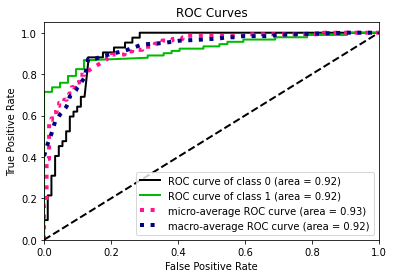

0.9195447409733124


In [28]:
plot_roc(Y_test, svm_model.predict_proba(X_test_vec))
plt.show()
print(roc_auc_score(Y_test, y_test_pred_proba[:,1], average="macro"))

In [29]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [30]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear', 'poly'],
              'class_weight':['balanced', None],
}

In [31]:
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring = "accuracy", cv=kfold, verbose=3)
grid.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.784 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.711 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.792 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.708 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.823 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.835 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.792 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=lin

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy', verbose=3)

In [32]:
print(grid.best_params_)

{'C': 1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


In [33]:
grid_predictions = grid.predict(X_test_vec)
print(classification_report(Y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.70      0.88      0.78        42
           1       0.94      0.82      0.88        91

    accuracy                           0.84       133
   macro avg       0.82      0.85      0.83       133
weighted avg       0.86      0.84      0.85       133



In [38]:
review = """It sounds terrible, bad user experience"""

review_tok = tokenize_list_of_text([review], custom_stopwords, True, 2)[1]
print(review_tok)
review_vec = review_vectors(review_tok[0], w2v_model.vector_size, [1 for x in range(len(review_tok[0]))])
pred = grid.predict(review_vec)
pred

total number of types extracted is: 5
[['sound_VBZ', 'terrible_JJ', 'bad_JJ', 'user_NN', 'experience_NN']]
non trovo user_NN


array([0])